# Let's see if it's working

In [1]:
import torch

import matplotlib.pyplot as plt

from nn.sequential import *
from nn.activation import *
from nn.linear import *
from nn.loss import *

In [2]:
def gen_data(n):
    x = torch.rand((2 * n, 2))
    pi = torch.acos(torch.zeros(1)).item() * 2
    target = ((x - torch.Tensor([0.5, 0.5])).pow(2).sum(dim=1) <= 1/(2*pi)) * 1

    x_train, x_test = x[:n], x[n:]
    y_train, y_test = target[:n], target[n:]
    return x_train, x_test, y_train.view(-1, 1), y_test.view(-1, 1)

torch.Size([1000])


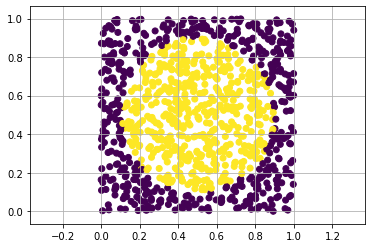

In [6]:
# Create test data
x_train, x_test, y_train, y_test = gen_data(1000)

# Plot test data
plt.scatter(x_train.numpy()[:,0], x_train.numpy()[:,1], c=y_train[:, 0])
plt.axis('equal')
plt.grid()
plt.show()

In [7]:
# Define network
LinNet = Sequential((
    Linear(2, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 1)),
    MSELoss()
)

In [8]:
LinNet.print()

Sequential((
Linear(2, 25), 
ReLU(), 
Linear(25, 25), 
ReLU(), 
Linear(25, 25), 
ReLU(), 
Linear(25, 1), 
))


In [9]:
# Iterate over samples in x
train_loss = []
for i in range(len(x_train)):
    # Get one data sample
    x_sample = x_train[i]
    y_sample = y_train[i]
    print(x_sample, y_sample)

    # Forward
    out = LinNet(x_sample)
    print(out)
    loss = LinNet.loss(out, y_sample)
    train_loss.append(loss)

    # Backward
    LinNet.backward()

    # Update params
    LinNet.update_params(optim='sgd', lr=0.01)

([nan])
tensor([0.0434, 0.7943]) tensor([0])
tensor([nan])
tensor([0.5174, 0.2452]) tensor([1])
tensor([nan])
tensor([0.2642, 0.4870]) tensor([1])
tensor([nan])
tensor([0.2522, 0.0959]) tensor([0])
tensor([nan])
tensor([0.5598, 0.0697]) tensor([0])
tensor([nan])
tensor([0.5605, 0.2937]) tensor([1])
tensor([nan])
tensor([0.1256, 0.1793]) tensor([0])
tensor([nan])
tensor([0.4452, 0.7819]) tensor([1])
tensor([nan])
tensor([0.6568, 0.6181]) tensor([1])
tensor([nan])
tensor([0.8226, 0.1782]) tensor([0])
tensor([nan])
tensor([0.8219, 0.4993]) tensor([1])
tensor([nan])
tensor([0.7351, 0.7356]) tensor([1])
tensor([nan])
tensor([0.5220, 0.0117]) tensor([0])
tensor([nan])
tensor([0.4974, 0.9540]) tensor([0])
tensor([nan])
tensor([0.8654, 0.9444]) tensor([0])
tensor([nan])
tensor([0.7881, 0.6843]) tensor([1])
tensor([nan])
tensor([0.0953, 0.5500]) tensor([0])
tensor([nan])
tensor([0.1877, 0.9474]) tensor([0])
tensor([nan])
tensor([0.5363, 0.8917]) tensor([1])
tensor([nan])
tensor([0.4168, 0.1722]

In [10]:
train_loss

[tensor(748.0678),
 tensor(5.8282e+08),
 tensor(2.9735e+32),
 tensor(inf),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 